In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import matplotlib.pyplot as plt


In [2]:
# GPU or CPU device to use
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [3]:
Width = 256
Height = 256
K = 20

category = ['Aeroplanes', 'Bicycles', 'Birds', 'Boats', 'Bottles', 
            'Buses', 'Cars', 'Cats', 'Chairs', 'Cows', 
            'Dining tables', 'Dogs', 'Horses', 'Motorbikes', 'People',
            'Potted plants', 'Sheep', 'Sofas',  'Trains', 'TV/Monitors']

In [22]:
from torchvision import datasets, transforms
from PIL import Image

class VOCSegmentationAug(datasets.VOCSegmentation):
    def __init__(self, root, year, image_set, download, transform, target_transform):
        super().__init__(root, year, image_set, download, transform, target_transform)
        self.transform = transforms.Compose([transforms.Resize((Height, Width)),
                                             transforms.ToTensor()])
        
    def _rotate(self, x, y):
        rotate = np.random.randint(-90, 90)
        return x.rotate(rotate), y.rotate(rotate)
    
    def _flip(self, x, y):
        p = np.random.uniform(0, 1)
        if p < 0.5:
            return x.transpose(Image.FLIP_TOP_BOTTOM), y.transpose(Image.FLIP_TOP_BOTTOM) 
        else:
            return x, y
        
    def _mirror(self, x, y):
        p = np.random.uniform(0, 1)
        if p < 0.5:
            return x.transpose(Image.FLIP_LEFT_RIGHT), y.transpose(Image.FLIP_LEFT_RIGHT)
        else:
            return x, y
    
    def _transform(self, x, y):
        return self.transform(x), self.transform(y)
        
    def __getitem__(self, index):
        x, y = super().__getitem__(index)
        x, y = self._rotate(x, y)
        x, y = self._flip(x, y)
        x, y = self._mirror(x, y)
        x, y = self._transform(x, y)
        y = (y * 255).long()[0]
        
        return x, y
                                   
train_data = VOCSegmentationAug(root='voc', year='2012', image_set='train', 
                               download=True, 
                               transform=None, 
                               target_transform=None)        

Using downloaded and verified file: voc/VOCtrainval_11-May-2012.tar


In [23]:
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=4, num_workers=1, shuffle=True)
print(train_loader)

In [6]:
import torch
from torch import nn
from torch.nn import functional as F

In [7]:
N = len(train_data)
dropout = 0.05
lengthscale = 1e-2
tau = 1.0

class DropoutConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0, bias=True):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                              kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)
        
    def forward(self, x):
        x = self.conv(x)
        return x
            
class DownConv(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.module_list = nn.ModuleList([nn.Sequential(DropoutConv2d(in_channels=in_channels, 
                                                        out_channels=hidden_channels, 
                                                        kernel_size=2, stride=2, bias=False),
                                                        nn.InstanceNorm2d(num_features=hidden_channels),
                                                        nn.ReLU()),

                                          nn.Sequential(DropoutConv2d(in_channels=hidden_channels, 
                                                        out_channels=hidden_channels,
                                                        kernel_size=3, padding=1),
                                                        nn.InstanceNorm2d(num_features=hidden_channels),
                                                        nn.ReLU()),
                                          
                                          DropoutConv2d(in_channels=hidden_channels, 
                                                        out_channels=out_channels, 
                                                        kernel_size=1)])
    def forward(self, x):
        x = self.module_list[0](x)
        x = self.module_list[1](x)
        x = self.module_list[2](x)
        
        return x
    
class UpConv(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.module_list = nn.ModuleList([nn.Sequential(nn.ConvTranspose2d(in_channels=in_channels, out_channels=hidden_channels, 
                                                                           kernel_size=2, stride=2, bias=False),
                                                        nn.InstanceNorm2d(num_features=hidden_channels),
                                                        nn.ReLU()),
                                         
                                          nn.Sequential(DropoutConv2d(in_channels=hidden_channels, 
                                                                      out_channels=hidden_channels,
                                                                      kernel_size=3, padding=1),
                                                        nn.InstanceNorm2d(num_features=hidden_channels),
                                                        nn.ReLU()),
                                                        
                                          DropoutConv2d(in_channels=hidden_channels, 
                                                        out_channels=out_channels, 
                                                        kernel_size=1)])
    
    def forward(self, x):
        x = self.module_list[0](x)
        x = self.module_list[1](x)
        x = self.module_list[2](x)
        
        return x
        
class Unet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Unet

        self.prenet = DropoutConv2d(in_channels=3, out_channels=16, kernel_size=1)
        
        self.downs = nn.ModuleList([DownConv(16, 32, 16),
                                    DownConv(16, 64, 32),
                                    DownConv(32, 128, 64),
                                    DownConv(64, 256, 128),
                                    DownConv(128, 512, 256)])
             
        self.ups = nn.ModuleList([UpConv(256, 512, 128),
                                  UpConv(256, 512, 64),
                                  UpConv(128, 256, 32),
                                  UpConv(64, 128, 16),
                                  UpConv(32, 64, 16)])
        
        self.postnet = DropoutConv2d(in_channels=16, out_channels=K, kernel_size=3, padding=1)
        
    def forward(self, x):
        # x : (b, c, h, w)
        
        xs = []
        # 1
        x = self.prenet(x)
        xs.append(x)
        # 1/2, 1/4, 1/8, 1/16
        for i, down in enumerate(self.downs):
            x = down(x)
            xs.append(x)
        
        x = None
        outputs = []
        for up in self.ups:
            if x is None:
                x = xs.pop()
            else:
                x = torch.cat([x, xs.pop()], dim=1)
            
            x = up(x)
        
        x = self.postnet(x)
        
        return x
    
print('done')

done


In [9]:
model = Unet().cuda()
saved_model = torch.load('cityscape_uncertainty.pth')
model.load_state_dict(saved_model.state_dict())

reg = lengthscale**2 * (1 - dropout) / (2. * N * tau)
optimizer = torch.optim.Adam(model.parameters(), 1e-3, weight_decay=reg)

def sizeof_fmt(num, suffix='B'):
    """
    Given `num` bytes, return human readable size.
    Taken from https://stackoverflow.com/a/1094933
    """
    for unit in ['', 'Ki', 'Mi', 'Gi', 'Ti', 'Pi', 'Ei', 'Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

size = sizeof_fmt(4 * sum(p.numel() for p in model.parameters()))
print(f"Model size {size}")

Model size 40.0MiB


1.Aeroplanes 2.Bicycles 3.Birds 4.Boats 5.Bottles 6.Buses 7.Cars 8.Cats 9.Chairs 10.Cows 11.Dining tables 12.Dogs 13.Horses 14.Motorbikes 15.People 16.Potted plants 17.Sheep 18.Sofas 19.Trains 20.TV/Monitors 


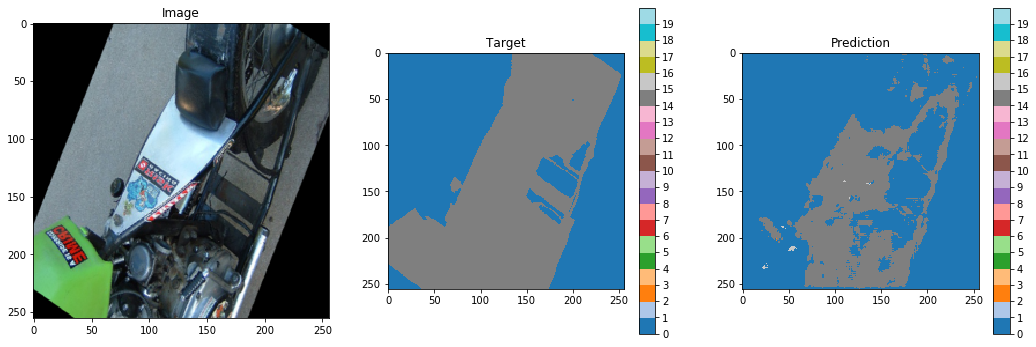

step: 1220 loss: 0.4618675112724304
step: 1240 loss: 0.3857167959213257
step: 1260 loss: 0.4838768243789673


KeyboardInterrupt: 

In [28]:
from IPython import display
import matplotlib.pyplot as plt

step = 0

while(True):
    for i, batch in enumerate(train_loader):
        x, y = batch
        x = x.cuda()
        y = y.cuda()
        y[torch.where(y==255)] = 0

        model.train()
        model.zero_grad()
        o = model(x)
        
        loss = nn.CrossEntropyLoss()(o, y)
        loss.backward()        
        optimizer.step()
        
        if step % 20 == 0:
            print('step:', step, 'loss:', loss.item())
        
        if step % 100 == 0:
            display.clear_output()
            
            string = ''
            for index, cat in enumerate(category):
                string += str(index+1) + '.' + cat + ' '
            print(string)
            
            plt.figure(figsize=[18, 6])
            plt.subplot(1, 3, 1)
            plt.title('Image')
            _x = x[0].data.cpu().numpy()
            plt.imshow(_x.transpose(1, 2, 0))

            plt.subplot(1, 3, 2)
            plt.title('Target')
            _y = y[0].data.cpu().numpy()
            plt.imshow(_y, vmin=0, vmax=20, cmap='tab20')
            plt.colorbar(ticks=np.arange(0, 20))

            plt.subplot(1, 3, 3)
            plt.title('Prediction')
            _o = torch.argmax(o[0], dim=0)
            _o = _o.data.cpu().numpy()
            plt.imshow(_o, vmin=0, vmax=20, cmap='tab20')
            plt.colorbar(ticks=np.arange(0, 20))
            plt.show()
            
        step += 1
        

In [29]:
torch.save(model, 'cityscape_uncertainty.pth')
print('done')

done
